In [12]:
import pymc3 as pm
import scipy.stats as stats
from IPython.core.pylabtools import figsize
%matplotlib inline

#### Bayesian A/B testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results.

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards.  

##### A Simple Case

We'll continue with the web-dev example. For the moment, we will focus on the analysis of site A only. Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us. 

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the *observed frequency* and the *true frequency* of an event. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$. Knowing the true frequency of events like:

- fraction of users who make purchases, 
- frequency of social attributes, 
- percent of internet users with cats etc. 

are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must *infer* it from observed data.

The *observed frequency* is then the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency, 0.2, differs from the true frequency, $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.


With respect to our A/B example, we are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be. 

To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. *A priori*, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [2]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data.

In [6]:
p_true = .05
N = 1500

# each random variable has a .05 chance of being a 1.
occurrences = stats.bernoulli.rvs(p_true, size=N)
print(occurrences)
print(np.sum(occurrences))  # True == 1, False == 0

[0 0 0 ... 0 0 0]
92


In [7]:
print(f"What is the observed frequency in group A? {np.mean(occurrences):.4f}")
print(f"Does this equal the true frequency? {(np.mean(occurrences) == p_true)}")

What is the observed frequency in group A? 0.0613
Does this equal the true frequency? False


In [8]:
with model:
    obs = pm.Bernoulli('obs', p, observed=occurrences)
    step = pm.Metropolis()
    trace = pm.sample(18_000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p]
Sampling 2 chains, 0 divergences: 100%|██████████| 37000/37000 [00:13<00:00, 2653.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


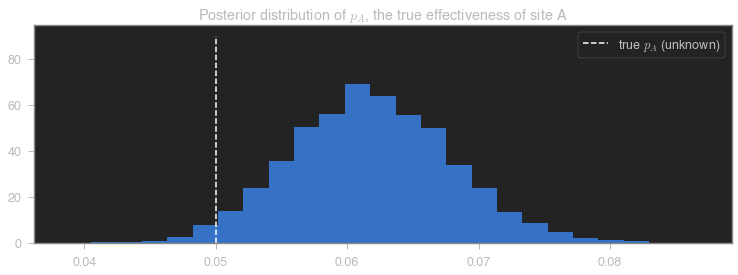

In [13]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)", 
           colors='w')
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend();

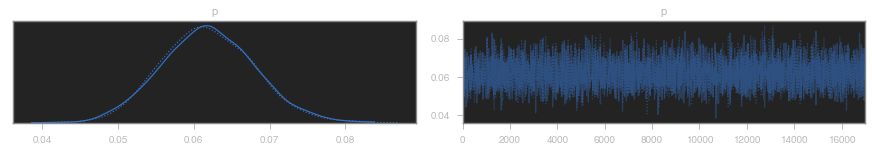

In [14]:
pm.traceplot(burned_trace);

Our posterior distribution puts most weight near the true value of $p_A$, but also some weights in the tails. Actually the most weight is near 0.06. This is a measure of how uncertain we should be, given our observations.

### *A* and *B* Together

A similar analysis can be done for site B's response data to determine the analogous $p_B$. But what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, *and* $\text{delta} = p_A - p_B$, all at once. We can do this using PyMC3's deterministic variables. (We'll assume that $p_B = 0.04$, so $\text{delta} = 0.01$, $N_B = 750$ (significantly less than $N_A$) and we will simulate site B's data like we did for site A's data )

In [15]:
# these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

# generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print(f"Obs from Site A: {observations_A[:30]} ... -- Mean: {np.mean(observations_A):.3f}")
print(f"Obs from Site B: {observations_B[:30]} ... -- Mean: {np.mean(observations_B):.3f}")

Obs from Site A: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ... -- Mean: 0.043
Obs from Site B: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ... -- Mean: 0.033


In [16]:
with pm.Model() as model:
    # assume Uniform priors for p_A and p_B
    p_A = pm.Uniform('p_A', 0, 1)
    p_B = pm.Uniform('p_B', 0, 1)
    
    # define the Deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic('delta', p_A - p_B)
    
    obs_A = pm.Bernoulli('obs_A', p_A, observed=observations_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=observations_B)
    
    step = pm.Metropolis()
    trace = pm.sample(20_000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [00:20<00:00, 1984.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


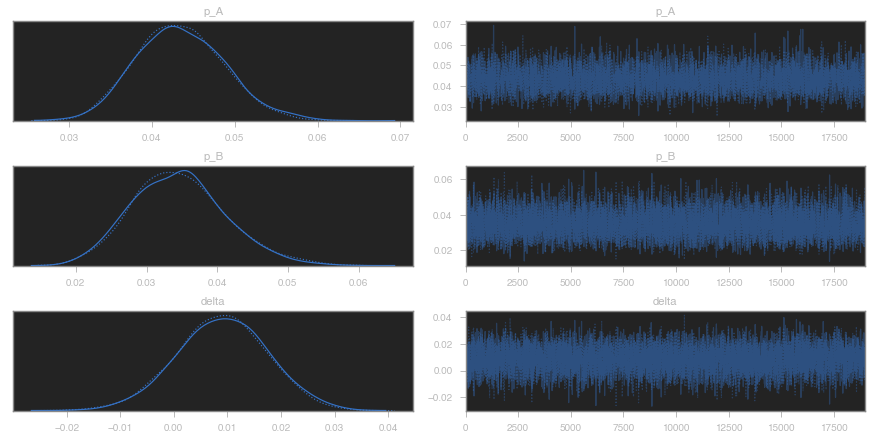

In [17]:
pm.traceplot(burned_trace);

Notice that as a result of `N_B < N_A`, i.e. we have less data from site B, our posterior distribution of $p_B$ is fatter, implying we are less certain about the true value of $p_B$ than we are of $p_A$.  

With respect to the posterior distribution of $\text{delta}$, we can see that the majority of the distribution is above $\text{delta}=0$, implying there site A's response is likely better than site B's response. The probability this inference is incorrect is easily computable:

In [18]:
p_A_samples = burned_trace['p_A']
p_B_samples = burned_trace['p_B']
delta_samples = burned_trace['delta']

In [27]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print(f'Probability site A is worse than site B: {(np.mean(delta_samples < 0)*100):.2f}%')
print(f'Probability site A is better than site B: {(np.mean(delta_samples > 0)*100):.2f}%')

Probability site A is worse than site B: 14.77%
Probability site A is better than site B: 85.23%


If this probability is too high for comfortable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A). 

Notice in all this, the difference in sample sizes between site A and site B was never mentioned: it naturally fits into Bayesian analysis.